# Importing Library 

In [377]:
import pandas as pd 
import numpy as np 
from surprise import Dataset
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import GridSearchCV
from IESEGRecSys import eval
from IESEGRecSys.model import ContentBased
import seaborn as sns
from sklearn.model_selection import train_test_split


# NLP packages
import nltk # pip install nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
pd.set_option('display.max_colwidth', 1000000)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vrajagopalan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vrajagopalan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Reading the data

## Data Exploration Artist

In [378]:
artist = pd.read_table("./data/Artists.dat", encoding='latin-1')

In [379]:
artist.head()

,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717.jpg
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835.png
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013.jpg


In [380]:
artist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17632 entries, 0 to 17631
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          17632 non-null  int64 
 1   name        17632 non-null  object
 2   url         17632 non-null  object
 3   pictureURL  17188 non-null  object
dtypes: int64(1), object(3)
memory usage: 551.1+ KB


## Data Exploration User Artist

In [381]:
user_artists = pd.read_table("./data/user_artists.dat", encoding='latin-1')

In [382]:
user_artists.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


Checking distribution for the weights

(0.0, 1500.0)

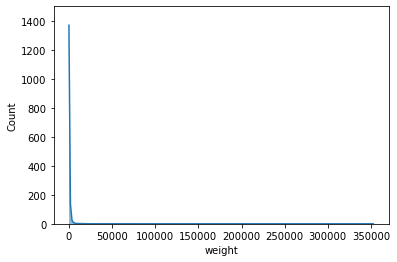

In [383]:
import matplotlib.pyplot as plt

sns.histplot(data=user_artists, x='weight', kde=True)
plt.ylim(0, 1500)


#### We will normalize the weight column using log transformation and divide the column by a constant 2.6 to ensure values are in range of 0 to 5

In [384]:
user_artists['raw_ratings'] = user_artists['weight'].map(lambda x: np.ceil(np.log(x)))

Lets Plot the ratings

<AxesSubplot:xlabel='raw_ratings', ylabel='Count'>

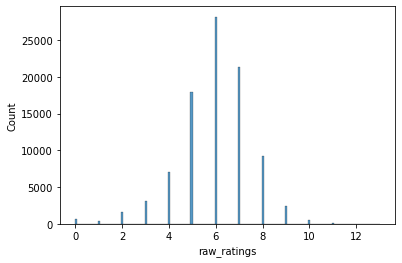

In [385]:
sns.histplot(user_artists['raw_ratings'])

In [386]:
user_artists['raw_ratings'].describe()

count    92834.000000
mean         5.965595
std          1.571694
min          0.000000
25%          5.000000
50%          6.000000
75%          7.000000
max         13.000000
Name: raw_ratings, dtype: float64

Drop rows with ratings 0

In [387]:
user_artists = user_artists[user_artists['raw_ratings'] > 0]

In [388]:
user_artists['raw_ratings'].describe()

count    92198.000000
mean         6.006746
std          1.496687
min          1.000000
25%          5.000000
50%          6.000000
75%          7.000000
max         13.000000
Name: raw_ratings, dtype: float64

In [389]:
user_artists['raw_ratings'].value_counts()

6.0     28177
7.0     21355
5.0     17976
8.0      9172
4.0      7052
3.0      3162
9.0      2489
2.0      1593
10.0      587
1.0       419
11.0      165
12.0       41
13.0       10
Name: raw_ratings, dtype: int64

## Data Exploration Tags

In [390]:
tags = pd.read_table("./data/tags.dat", encoding='latin-1')

In [391]:
tags.head()

,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal


In [392]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11946 entries, 0 to 11945
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tagID     11946 non-null  int64 
 1   tagValue  11946 non-null  object
dtypes: int64(1), object(1)
memory usage: 186.8+ KB


## Data Exploration User Tagged Artists

In [393]:
user_taggedartists = pd.read_table("./data/user_taggedartists.dat", encoding='latin-1')

In [394]:
user_taggedartists.head()

,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009


In [395]:
user_taggedartists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186479 entries, 0 to 186478
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   userID    186479 non-null  int64
 1   artistID  186479 non-null  int64
 2   tagID     186479 non-null  int64
 3   day       186479 non-null  int64
 4   month     186479 non-null  int64
 5   year      186479 non-null  int64
dtypes: int64(6)
memory usage: 8.5 MB


In [396]:
user_taggedartists['date'] = pd.to_datetime((user_taggedartists[["year", "month", "day"]]))

In [397]:
user_taggedartists.drop('day', inplace =  True, axis = 1)
user_taggedartists.drop('month', inplace =  True, axis = 1)
user_taggedartists.drop('year', inplace =  True, axis = 1)
user_taggedartists.head()

,userID,artistID,tagID,date
0,2,52,13,2009-04-01
1,2,52,15,2009-04-01
2,2,52,18,2009-04-01
3,2,52,21,2009-04-01
4,2,52,41,2009-04-01


In [398]:
user_taggedartists.shape

(186479, 4)

We will now merge the tags table with user_taggedartists table

In [399]:
tmp = user_taggedartists.merge(tags, left_on='tagID', right_on = 'tagID', how = 'left')

In [400]:
tmp.head()

,userID,artistID,tagID,date,tagValue
0,2,52,13,2009-04-01,chillout
1,2,52,15,2009-04-01,downtempo
2,2,52,18,2009-04-01,electronic
3,2,52,21,2009-04-01,trip-hop
4,2,52,41,2009-04-01,female vovalists


#### Lets get all the tags for a user and append it to a list

In [401]:
aggregate_1 = tmp.groupby('artistID')['tagValue'].apply(list)

In [402]:
aggregate_1.head()

artistID
1                                                                                                              [weeabo, jrock, j-rock, visual kei, better than lady gaga, j-rock, visual kei, gothic, japanese, j-rock, visual kei, gothic, japanese, j-rock, j-rock]
2    [german, seen live, darkwave, industrial, german, german, gothic, darkwave, ambient, dark, vocal, gothic, darkwave, electronic, german, seen live, gothic, darkwave, darkwave, darkwave, true goth emo, german, gothic, gothic rock, darkwave, gothic, darkwave]
3                                                                                                    [black metal, black metal, norwegian black metal, true norwegian black metal, very kvlt, norsk arysk metal, black metal, true norwegian black metal, saxophones]
4                                                    [j-rock, visual kei, metal, gothic japanese, bazarov, metal, rock, j-rock, visual kei, gothic, japanese, gothic metal, j-rock, gothic, japanese, j-rock,

In [403]:
aggregate_1 = pd.DataFrame(aggregate_1)

In [404]:
aggregate_1['tagValue'] = aggregate_1['tagValue'].map(lambda x : np.unique(x))

In [405]:
aggregate_1.head()

,tagValue
artistID,
1,"[better than lady gaga, gothic, j-rock, japanese, jrock, visual kei, weeabo]"
2,"[ambient, dark, darkwave, electronic, german, gothic, gothic rock, industrial, seen live, true goth emo, vocal]"
3,"[black metal, norsk arysk metal, norwegian black metal, saxophones, true norwegian black metal, very kvlt]"
4,"[bazarov, gothic, gothic japanese, gothic metal, j-rock, japanese, metal, rock, visual kei]"
5,"[covers, darkwave, deathrock, gothic, gothic rock]"


#### Lets calculate the frequency of users who have tagged per artist id and pivot

In [406]:
aggregate_2 = tmp.groupby(['artistID', 'userID'])['tagID'].count()

In [407]:
aggregate_2.describe()

count    71064.000000
mean         2.624099
std          2.835507
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         50.000000
Name: tagID, dtype: float64

In [408]:
aggregate_2 = aggregate_2.unstack().fillna(0)
aggregate_2.head()

userID,2,3,4,5,6,7,8,9,10,11,...,2090,2091,2092,2093,2094,2095,2096,2097,2099,2100
artistID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Lets calculate recency for the artistId by userID

In [409]:
aggregate_3 = tmp.groupby(['artistID', 'userID'])['date'].agg('max')

In [410]:
import datetime

aggregate_3 = pd.DataFrame(aggregate_3)
aggregate_3['recency'] = datetime.datetime.today() - pd.to_datetime(aggregate_3['date']) 
aggregate_3['recency'] = aggregate_3['recency'].dt.days
aggregate_3.drop('date', inplace =  True, axis = 1)
aggregate_3.head()

recency
artistID userID         
1        37         5001
         274        5062
         681        4970
         785        4240
         1545       5183

In [411]:
aggregate_3 =  aggregate_3.unstack().fillna(0)
aggregate_3.head()

recency                                               ...            \
userID      2    3    4    5    6    7    8    9    10   11    ... 2090 2091   
artistID                                                       ...             
1            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
3            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
4            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
5            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

                                                  
userID   2092 2093 2094 2095 2096 2097 2099 2100  
artistID                                          
1         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
5         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 1892 columns]

## Collaborative Filtering Approach

Lets split the userartist data into test and train 

In [412]:
data = user_artists.loc[:,['userID', 'artistID', 'raw_ratings']]

In [413]:
data.head()

,userID,artistID,raw_ratings
0,2,51,10.0
1,2,52,10.0
2,2,53,10.0
3,2,54,10.0
4,2,55,10.0


In [414]:
# train-test split
train, test = train_test_split(data, test_size=0.3, random_state=42)

# reset index
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

print(data.shape)
print(train.shape)
print(test.shape)

(92198, 3)
(64538, 3)
(27660, 3)


In [415]:
reader = Reader(rating_scale=(1, 10))
df_train = Dataset.load_from_df(train, reader).build_full_trainset()
df_test = list(test.itertuples(index=False, name=None))

In [416]:
data.reset_index()

,index,userID,artistID,raw_ratings
0,0,2,51,10.0
1,1,2,52,10.0
2,2,2,53,10.0
3,3,2,54,10.0
4,4,2,55,10.0
...,...,...,...,...
92193,92829,2100,18726,6.0
92194,92830,2100,18727,6.0
92195,92831,2100,18728,6.0
92196,92832,2100,18729,6.0


In [417]:
data.isna().sum()

userID         0
artistID       0
raw_ratings    0
dtype: int64

In [418]:
type(data)

pandas.core.frame.DataFrame

In [420]:
benchmark = []
data = Dataset.load_from_df(data[['userID', 'artistID', 'raw_ratings']], reader)
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


In [422]:
benchmark

[test_rmse    0.889587
 fit_time     7.960005
 test_time    0.655158
 Algorithm         SVD
 dtype: object,
 test_rmse      0.873931
 fit_time     111.885325
 test_time      4.696891
 Algorithm         SVDpp
 dtype: object,
 test_rmse     1.084175
 fit_time     19.503937
 test_time     2.321225
 Algorithm     SlopeOne
 dtype: object,
 test_rmse     1.397496
 fit_time     16.969504
 test_time     0.729625
 Algorithm          NMF
 dtype: object,
 test_rmse           2.113256
 fit_time            0.309215
 test_time           0.773833
 Algorithm    NormalPredictor
 dtype: object,
 test_rmse       0.976949
 fit_time        1.265436
 test_time       7.618275
 Algorithm    KNNBaseline
 dtype: object,
 test_rmse    1.391533
 fit_time     0.711529
 test_time    4.933831
 Algorithm    KNNBasic
 dtype: object,
 test_rmse        1.053448
 fit_time         0.757735
 test_time        5.666618
 Algorithm    KNNWithMeans
 dtype: object,
 test_rmse         1.059103
 fit_time          1.214986
 test_ti

#### Now we will try to train the surprise model to get ratings using matrix, user based, item based, coclustering  and ALS

In [ ]:
# item-based
options = {'name':'cosine', 'user_based':False}
ib = KNNBasic(k=15, min_k=5, sim_options=options, random_state=42)
ib.fit(df_train)
ib_pred = ib.test(df_test)

# True options is parm
options = {'name':'cosine', 'user_based':True} 
ub = KNNBasic(k=20, min_k=5, sim_options=options, random_state=42)
ub.fit(df_train)
ub_pred = ub.test(df_test)

# Co Clustering
clust = CoClustering(n_cltr_u=10, n_cltr_i=10, n_epochs=50, random_state=42)
clust.fit(df_train)
predclu = clust.test(df_test)

# svd
mf = SVD(n_factors=20, biased=False, random_state=42)
mf.fit(df_train)
mf_pred = mf.test(df_test)

options = {"method": "als", "n_epochs": 20}
als = BaselineOnly(bsl_options=options)
als.fit(df_train)
als_pred = als.test(df_test)

models = {"IB":ib_pred,"UB":ub_pred, "CLU":predclu, "SVD":mf_pred, "ALS":als_pred}
overview = pd.concat([eval.evaluate(mod, topn=5, rating_cutoff=5) for mod in models.values()], axis=1)
overview.columns = list(models.keys())
overview

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


<ipython-input-180-708261c26dbc>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  clust.fit(df_train)


Estimating biases using als...


,IB,UB,CLU,SVD,ALS
RMSE,1.155835,1.496085,1.114257,1.421003,0.940659
MAE,0.829390,1.128415,0.820945,1.004436,0.713441
Recall,0.955123,0.994916,0.925705,0.832660,0.975791
Precision,0.922934,0.867718,0.939723,0.942417,0.950985
F1,0.938753,0.926974,0.932662,0.884145,0.963228
NDCG@5,0.843581,0.856282,0.852969,0.859563,0.855251


### Predictions

We can see that ALS gives us the best RMSE followed by cluster based. We will now try to get top 5 artist using each of the predictions

In [ ]:
tmp.head()

,userID,artistID,tagID,date,tagValue
0,2,52,13,2009-04-01,chillout
1,2,52,15,2009-04-01,downtempo
2,2,52,18,2009-04-01,electronic
3,2,52,21,2009-04-01,trip-hop
4,2,52,41,2009-04-01,female vovalists


### Lets check the Tags of USER 200

In [ ]:
user_200 = tmp.groupby('userID')['tagValue'].apply(list)
pd.DataFrame(user_200[user_200.index == 200])

,tagValue
userID,
200,"[rock, classic rock, british, hard rock, nwobhm, ambient, new age, instrumental, progressive rock, rock]"


In [ ]:
from IESEGRecSys import utils

results = utils.get_top_n(als_pred,  n = 5,  user_col =  'userID', item_col='artistID')
results.head()

,user,item
0,200,"[65, 4125, 4130, 998, 4131]"
1,1833,"[292, 295, 4252, 299, 86]"
2,293,"[679, 227, 498, 230, 412]"
3,1102,"[906, 467, 2020, 298, 97]"
4,938,"[300, 5459, 291, 499, 680]"


Lets check the tags for user 200 based on ALS algorithm for artistID 65, 4125, 4130

In [ ]:
result = pd.DataFrame(aggregate_1[aggregate_1.index == 65])
result.head()

,tagValue
artistID,
65,"[00s, 2002, 2005, 2008, 4m4zinq, 90s, acoustic, alternative, alternative rock, amazing, ambient, atmospheric, awesome, b-side, ballad, beatiful, beautiful, beautiful music, ben lee, best songs ever, brian eno, brilliant, brit rock, british, britpop, britrock, britsong, caaamiiiliiitaaa, chill, chillout, cities, classic rock, cold play, coldplay, cool, cover, cute, demo, dreamy, electronic, epic, eternal love, european, experimental, fail, favorite albums, favorite artist, favorite artists, favorite bands, favorite bands and artists, favorite song, favorite songs, favorites, favourite, favourite artists, favourite songs, favourites, folk, free, free download, free mp3, fucking awesome, fun, galactic, garden state soundtrack, genius, gold, good stuff, great song, hang on, happy, i love, indie, indie pop, indie rock, indierock, inlove, isa, johnny cash, jukebox project, just chillin, kraftwerk, lastfm elitist repellent, lights, listened more than 10 times in a row, love, love at first listen, love it, love ya lll, lovely, lpa, male vocalists, marisa mix, melancholic, mellow, metal, musikfuerrundumdieuhr, muzyka dla mietkich chlopcow, my own private sunshine, naked, ...]"


In [ ]:
result = pd.DataFrame(aggregate_1[aggregate_1.index == 4125])
result.head()

,tagValue
artistID,
4125,"[1991, 60s, 70s, 80s, 90s, alan lancaster, andy bown, best christmas songs, british, classic rock, england, francis rossi, guitar, hard rock, jeff rich, john coghlan, male vocalists, matt letley, pop, pop rock, psychedelic, rhino edwards, rick parfitt, rock, rock and roll, rock n roll, soft rock]"


In [ ]:
result = pd.DataFrame(aggregate_1[aggregate_1.index == 4130])
result.head()

,tagValue
artistID,
4130,"[1984, 70s, 70ss, 80s, b side, ballad, classic, classic rock, cold case soundtrack, favorites, good memories, hard rock, hidden gem, late night love, late night tunes, love making music, male vocals, mellow, one of their best, pop, progressive rock, random songs, rock, seen in concert, seen live, soft rock, ultimate rock ballads]"


We see that the 3 artist predicted for the user is mostly having tags associated with rock music. Lets repeat this activity for Co Clustering results as well

In [ ]:
results = utils.get_top_n(predclu,  n = 5,  user_col =  'userID', item_col='artistID')
results.head()

,user,item
0,200,"[4131, 4124, 998, 4130, 65]"
1,1833,"[292, 4252, 16916, 299, 295]"
2,293,"[5307, 230, 5311, 5309, 5323]"
3,1102,"[467, 58, 906, 97, 298]"
4,938,"[7191, 300, 9193, 499, 9187]"


Lets check the tags for user 200 based on ALS algorithm for artistID 4131, 4124, 998

In [ ]:
result = pd.DataFrame(aggregate_1[aggregate_1.index == 4131])
result.head()

,tagValue
artistID,
4131,"[british, english]"


In [ ]:
result = pd.DataFrame(aggregate_1[aggregate_1.index == 4124])
result.head()

,tagValue
artistID,
4124,"[70s, classic rock, favorite songs, guilty pleasure, hard rock, heavy metal, late night tunes, progressive rock, really sad thing, rock, space rock, stoner rock, top]"


In [ ]:
result = pd.DataFrame(aggregate_1[aggregate_1.index == 998])
result.head()

,tagValue
artistID,
998,"[1008, 80s, 80s pop, alternative, alternative dance, b-side, beautiful, blitz playlist, british, british artists, cities, covers, death, drugs, edit, electronic, experimental, factory records, famous persons, fav artists, favorite bands, favorite tracks, instrumental, level one, liverpool, mad about, my loving, my pleasuredome, new romantic, new wave, old, omd, piano, po-kraftwerkski, pop, random songs, religion, science, slowies, soundtrack, synth pop, synthpop, synthpop artists, the beowulfs choice]"


The results suggest the songs are similar as they are British but 4124 does not seem to have any tags in common.

## Lets try to improve our RMSE and predictions using content based appraoch

We will first do content based on the basis of tags that we have aggregated

In [ ]:
aggregate_1.head()

,tagValue
artistID,
1,"[better than lady gaga, gothic, j-rock, japanese, jrock, visual kei, weeabo]"
2,"[ambient, dark, darkwave, electronic, german, gothic, gothic rock, industrial, seen live, true goth emo, vocal]"
3,"[black metal, norsk arysk metal, norwegian black metal, saxophones, true norwegian black metal, very kvlt]"
4,"[bazarov, gothic, gothic japanese, gothic metal, j-rock, japanese, metal, rock, visual kei]"
5,"[covers, darkwave, deathrock, gothic, gothic rock]"


In [ ]:
aggregate_1['tagValue_token'] = aggregate_1['tagValue'].apply(lambda x : ''.join(str(e) for e in x).replace('[^a-zA-Z0-9 ]', ''))

In [ ]:
aggregate_1.head()

,tagValue,tagValue_token
artistID,,
1,"[better than lady gaga, gothic, j-rock, japanese, jrock, visual kei, weeabo]",better than lady gagagothicj-rockjapanesejrockvisual keiweeabo
2,"[ambient, dark, darkwave, electronic, german, gothic, gothic rock, industrial, seen live, true goth emo, vocal]",ambientdarkdarkwaveelectronicgermangothicgothic rockindustrialseen livetrue goth emovocal
3,"[black metal, norsk arysk metal, norwegian black metal, saxophones, true norwegian black metal, very kvlt]",black metalnorsk arysk metalnorwegian black metalsaxophonestrue norwegian black metalvery kvlt
4,"[bazarov, gothic, gothic japanese, gothic metal, j-rock, japanese, metal, rock, visual kei]",bazarovgothicgothic japanesegothic metalj-rockjapanesemetalrockvisual kei
5,"[covers, darkwave, deathrock, gothic, gothic rock]",coversdarkwavedeathrockgothicgothic rock


In [ ]:
# Tokenize, case conversion & only alphabetic
tokens = aggregate_1['tagValue_token'].apply(lambda txt: [word.lower() for word in word_tokenize(str(txt)) if word.isalpha()])

In [ ]:
# setup stop words list
stop_words = stopwords.words('english')
stop_words.append('nan')

stemmer = SnowballStemmer("english")

# remove stopwords
# stem
token_stem = tokens.apply(lambda lst_token: [stemmer.stem(tok) for tok in lst_token if tok not in stop_words and len(tok) > 2])

In [ ]:
# TFIDF vectorizer
tfidf = TfidfVectorizer(min_df=5)

# apply tf-idf vectorizer -> document-term-matrix in sparse format
dtm = tfidf.fit_transform([" ".join(x) for x in token_stem])

print(dtm.shape)

df_dtm = pd.DataFrame(dtm.toarray(), columns=tfidf.get_feature_names_out(), index=aggregate_1.index)
df_dtm.head()

(12523, 1222)


,absolut,abstract,acid,acoust,acousticacoust,acousticalternativealtern,acousticalternativefemal,acousticfemal,actual,adam,...,would,write,yet,york,yorknew,yorkshir,your,zealand,zonechristma,zoneclass
artistID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# init content-based
cb = ContentBased(NN=10)

# fit on content
cb.fit(df_dtm)

In [ ]:
cb.fit_ratings(df_train)

# predict test ratings
cb_pred_1 = cb.test(df_test)

Warning 3929 items are not included in content data: [16385, 8194, 16387, 8197, 16389, 8200, 16393, 8203, 8204, 8206, 8207, 8209, 16404, 8213, 16408, 16410, 8220, 16417, 8227, 8228, 16419, 16420, 16423, 16425, 16426, 8236, 16428, 8238, 16429, 8240, 8242, 16439, 16443, 16444, 16445, 16451, 16455, 16456, 16457, 16458, 16461, 16465, 16467, 8282, 8284, 8285, 8289, 105, 16490, 109, 110, 111, 112, 8303, 8306, 115, 117, 118, 119, 123, 124, 125, 8316, 127, 8320, 129, 16507, 131, 16510, 133, 16513, 135, 136, 8327, 8330, 16514, 8332, 16518, 16519, 8335, 144, 145, 8337, 147, 8338, 8339, 150, 8342, 8344, 16530, 16535, 8352, 8355, 8357, 169, 177, 16561, 8373, 8374, 16565, 16569, 8379, 16572, 16573, 16576, 8385, 16580, 8389, 16583, 16584, 16585, 8394, 16588, 16590, 16592, 16594, 16596, 16598, 16599, 16601, 8410, 8411, 8413, 8414, 16605, 224, 8416, 16613, 16615, 8424, 16618, 8427, 8428, 16621, 8430, 16625, 242, 8434, 16631, 8440, 16632, 8442, 16635, 16636, 254, 8447, 8448, 8449, 8450, 8451, 8452, 166

c:\Users\vrajagopalan\OneDrive - IESEG\Desktop\Recommendation\Group_Assignment\IESEGRecSys\model.py:72: RuntimeWarning: invalid value encountered in true_divide
  self.prediction = (np.matmul(df_pivot.values, self.matrixNN) / denom) + self.user_avg[:,np.newaxis]


In [ ]:
overview

,IB,UB,CLU,SVD,ALS
RMSE,1.155835,1.496085,1.114257,1.421003,0.940659
MAE,0.829390,1.128415,0.820945,1.004436,0.713441
Recall,0.955123,0.994916,0.925705,0.832660,0.975791
Precision,0.922934,0.867718,0.939723,0.942417,0.950985
F1,0.938753,0.926974,0.932662,0.884145,0.963228
NDCG@5,0.843581,0.856282,0.852969,0.859563,0.855251


In [ ]:
overview = pd.concat([eval.evaluate(cb_pred_1, topn=5, rating_cutoff=5), overview], axis = 1)
overview.rename(columns={'value':'CB_TDIDF'}, inplace = True)
overview

,CB_TDIDF,IB,UB,CLU,SVD,ALS
RMSE,1.061201,1.155835,1.496085,1.114257,1.421003,0.940659
MAE,0.767399,0.829390,1.128415,0.820945,1.004436,0.713441
Recall,0.953873,0.955123,0.994916,0.925705,0.832660,0.975791
Precision,0.940703,0.922934,0.867718,0.939723,0.942417,0.950985
F1,0.947242,0.938753,0.926974,0.932662,0.884145,0.963228
NDCG@5,0.864106,0.843581,0.856282,0.852969,0.859563,0.855251


We will now try the contentbased model for frequency

In [ ]:
# init content-based
cb1 = ContentBased(NN=10)

# fit on content
cb1.fit(aggregate_2)
cb1.fit_ratings(df_train)

# predict test ratings
cb_pred_2 = cb1.test(df_test)

Warning 3929 items are not included in content data: [16385, 8194, 16387, 8197, 16389, 8200, 16393, 8203, 8204, 8206, 8207, 8209, 16404, 8213, 16408, 16410, 8220, 16417, 8227, 8228, 16419, 16420, 16423, 16425, 16426, 8236, 16428, 8238, 16429, 8240, 8242, 16439, 16443, 16444, 16445, 16451, 16455, 16456, 16457, 16458, 16461, 16465, 16467, 8282, 8284, 8285, 8289, 105, 16490, 109, 110, 111, 112, 8303, 8306, 115, 117, 118, 119, 123, 124, 125, 8316, 127, 8320, 129, 16507, 131, 16510, 133, 16513, 135, 136, 8327, 8330, 16514, 8332, 16518, 16519, 8335, 144, 145, 8337, 147, 8338, 8339, 150, 8342, 8344, 16530, 16535, 8352, 8355, 8357, 169, 177, 16561, 8373, 8374, 16565, 16569, 8379, 16572, 16573, 16576, 8385, 16580, 8389, 16583, 16584, 16585, 8394, 16588, 16590, 16592, 16594, 16596, 16598, 16599, 16601, 8410, 8411, 8413, 8414, 16605, 224, 8416, 16613, 16615, 8424, 16618, 8427, 8428, 16621, 8430, 16625, 242, 8434, 16631, 8440, 16632, 8442, 16635, 16636, 254, 8447, 8448, 8449, 8450, 8451, 8452, 166

c:\Users\vrajagopalan\OneDrive - IESEG\Desktop\Recommendation\Group_Assignment\IESEGRecSys\model.py:72: RuntimeWarning: invalid value encountered in true_divide
  self.prediction = (np.matmul(df_pivot.values, self.matrixNN) / denom) + self.user_avg[:,np.newaxis]


In [ ]:
overview = pd.concat([eval.evaluate(cb_pred_2, topn=5, rating_cutoff=5), overview], axis = 1)
overview.rename(columns={'value':'CB_FREQ'}, inplace = True)
overview

,CB_FREQ,CB_TDIDF,IB,UB,CLU,SVD,ALS
RMSE,1.002499,1.061201,1.155835,1.496085,1.114257,1.421003,0.940659
MAE,0.728852,0.767399,0.829390,1.128415,0.820945,1.004436,0.713441
Recall,0.950623,0.953873,0.955123,0.994916,0.925705,0.832660,0.975791
Precision,0.950267,0.940703,0.922934,0.867718,0.939723,0.942417,0.950985
F1,0.950445,0.947242,0.938753,0.926974,0.932662,0.884145,0.963228
NDCG@5,0.866111,0.864106,0.843581,0.856282,0.852969,0.859563,0.855251


And we see that for frequency based content based model we do get a better RMSE as compared to the CB_TDIF model

We will now try to fit the content based model for recency

In [ ]:
# init content-based
cb2 = ContentBased(NN=10)

# fit on content
cb2.fit(aggregate_3)
cb2.fit_ratings(df_train)

# predict test ratings
cb_pred_3 = cb2.test(df_test)

Warning 3929 items are not included in content data: [16385, 8194, 16387, 8197, 16389, 8200, 16393, 8203, 8204, 8206, 8207, 8209, 16404, 8213, 16408, 16410, 8220, 16417, 8227, 8228, 16419, 16420, 16423, 16425, 16426, 8236, 16428, 8238, 16429, 8240, 8242, 16439, 16443, 16444, 16445, 16451, 16455, 16456, 16457, 16458, 16461, 16465, 16467, 8282, 8284, 8285, 8289, 105, 16490, 109, 110, 111, 112, 8303, 8306, 115, 117, 118, 119, 123, 124, 125, 8316, 127, 8320, 129, 16507, 131, 16510, 133, 16513, 135, 136, 8327, 8330, 16514, 8332, 16518, 16519, 8335, 144, 145, 8337, 147, 8338, 8339, 150, 8342, 8344, 16530, 16535, 8352, 8355, 8357, 169, 177, 16561, 8373, 8374, 16565, 16569, 8379, 16572, 16573, 16576, 8385, 16580, 8389, 16583, 16584, 16585, 8394, 16588, 16590, 16592, 16594, 16596, 16598, 16599, 16601, 8410, 8411, 8413, 8414, 16605, 224, 8416, 16613, 16615, 8424, 16618, 8427, 8428, 16621, 8430, 16625, 242, 8434, 16631, 8440, 16632, 8442, 16635, 16636, 254, 8447, 8448, 8449, 8450, 8451, 8452, 166

c:\Users\vrajagopalan\OneDrive - IESEG\Desktop\Recommendation\Group_Assignment\IESEGRecSys\model.py:72: RuntimeWarning: invalid value encountered in true_divide
  self.prediction = (np.matmul(df_pivot.values, self.matrixNN) / denom) + self.user_avg[:,np.newaxis]


In [ ]:
overview = pd.concat([eval.evaluate(cb_pred_3, topn=5, rating_cutoff=5), overview], axis = 1)
overview.rename(columns={'value':'CB_REC'}, inplace = True)


In [ ]:
overview

,CB_REC,CB_FREQ,CB_TDIDF,IB,UB,CLU,SVD,ALS
RMSE,0.995778,1.002499,1.061201,1.155835,1.496085,1.114257,1.421003,0.940659
MAE,0.724015,0.728852,0.767399,0.829390,1.128415,0.820945,1.004436,0.713441
Recall,0.949873,0.950623,0.953873,0.955123,0.994916,0.925705,0.832660,0.975791
Precision,0.951657,0.950267,0.940703,0.922934,0.867718,0.939723,0.942417,0.950985
F1,0.950764,0.950445,0.947242,0.938753,0.926974,0.932662,0.884145,0.963228
NDCG@5,0.864225,0.866111,0.864106,0.843581,0.856282,0.852969,0.859563,0.855251


The recency based content based model performs the best in terms of RMSE but we still see that ALS gives us the best performance

In [ ]:
def predict_user_topn(model, train, user, topk=10, item_col='item'):
    """
    Returns topk items for specified user.
    Return type: list
    Args[model, train, user, topk, item_col]
    model:      fitted model (surprise package)
    train:      train set used to fit model
    user:       user id
    topk:       topk items to return
    item_col:   column containing item ids
    """

    # intermediate result dict
    res = {item_col:[], 'pred':[], 'detail':[]}
 
    # iter through all items contained in train set
    for item in set(train[item_col]) :
        uid, iid, true_r, est, detail = model.predict(user,item)
        if detail['was_impossible']: continue
        # save to result dict
        res[item_col].append(item)
        res['pred'].append(est)
        res['detail'].append(detail)


    return list(pd.DataFrame(res).sort_values('pred', ascending=False)[:topk][item_col])

Lets check the Recommendations for user 200 using the recency and Frequency content based model.

In [ ]:
train.head()

,userID,artistID,raw_ratings
0,967,3462,5.0
1,441,225,5.0
2,1356,466,8.0
3,1757,65,5.0
4,1515,344,6.0


In [ ]:
results = predict_user_topn(cb2, train, 200, topk=5, item_col='artistID')
results

[4126, 723, 5173, 607, 3269]

In [ ]:
result = pd.DataFrame(aggregate_1.loc[aggregate_1.index == 4126, 'tagValue'])
result.head()

,tagValue
artistID,
4126,"[1982, 60s, 80s, 90s, ambient, angelic, awesome, beautiful, best songs of the 80s, chef musinum, chill zone, chillout, electronic, electronica, epic, experimental, fallout, faves, instrumental, jean marc toma, lostfreeq, meditation, new age, new beat, piano, sensual, slowies, soundtrack, the best classical opera and film scores]"


In [ ]:
result = pd.DataFrame(aggregate_1.loc[aggregate_1.index == 723, 'tagValue'])
result.head()

,tagValue
artistID,
723,"[arkadi, folk, instrumental, jazz, latin, world]"


In [ ]:
result = pd.DataFrame(aggregate_1.loc[aggregate_1.index == 5173, 'tagValue'])
result.head()

,tagValue
artistID,
5173,"[drum and bass, electronic, experimental, instrumental, progressive, progressive rock, psychedelic]"


Lets make Predictions using content based frequency

In [ ]:
results = predict_user_topn(cb1, train, 200, topk=5, item_col='artistID')
results

[723, 963, 1148, 2343, 11484]

In [ ]:
result = pd.DataFrame(aggregate_1.loc[aggregate_1.index == 723, 'tagValue'])
result.head()

,tagValue
artistID,
723,"[arkadi, folk, instrumental, jazz, latin, world]"


In [ ]:
result = pd.DataFrame(aggregate_1.loc[aggregate_1.index == 963, 'tagValue'])
result.head()

,tagValue
artistID,
963,"[amazing, ambient, breathtaking, chillout, dreamy, fascinating, instrumental, new age, piano, rain, seen live]"


In [ ]:
result = pd.DataFrame(aggregate_1.loc[aggregate_1.index == 1148, 'tagValue'])
result.head()

,tagValue
artistID,
1148,"[ambient, coisa de deus, electronic, electronica, epic, japanese, new age]"


Lets make top 3 predictions for artist ID 65 using all three content based model and evaluate the results

Recommendations with TDIF content based model

In [ ]:
results = cb.get_most_similar(65, topn=3)
results

array([ 154, 4609, 1072], dtype=int64)

In [ ]:
result = pd.DataFrame(aggregate_1.loc[aggregate_1.index == 65, 'tagValue'])
result.head()

,tagValue
artistID,
65,"[00s, 2002, 2005, 2008, 4m4zinq, 90s, acoustic, alternative, alternative rock, amazing, ambient, atmospheric, awesome, b-side, ballad, beatiful, beautiful, beautiful music, ben lee, best songs ever, brian eno, brilliant, brit rock, british, britpop, britrock, britsong, caaamiiiliiitaaa, chill, chillout, cities, classic rock, cold play, coldplay, cool, cover, cute, demo, dreamy, electronic, epic, eternal love, european, experimental, fail, favorite albums, favorite artist, favorite artists, favorite bands, favorite bands and artists, favorite song, favorite songs, favorites, favourite, favourite artists, favourite songs, favourites, folk, free, free download, free mp3, fucking awesome, fun, galactic, garden state soundtrack, genius, gold, good stuff, great song, hang on, happy, i love, indie, indie pop, indie rock, indierock, inlove, isa, johnny cash, jukebox project, just chillin, kraftwerk, lastfm elitist repellent, lights, listened more than 10 times in a row, love, love at first listen, love it, love ya lll, lovely, lpa, male vocalists, marisa mix, melancholic, mellow, metal, musikfuerrundumdieuhr, muzyka dla mietkich chlopcow, my own private sunshine, naked, ...]"


In [ ]:
result = pd.DataFrame(aggregate_1.loc[aggregate_1.index == 154, 'tagValue'])
result.head()

,tagValue
artistID,
154,"[00s, 1995, 80s, 90s, <3, a piece of me, aana, acoustic, acoustic guitar, all time favorites, alternative, alternative rock, amazing, amazing singer, ambient, atari electronic, atmospheric, awesome, b-side, barkbarkdisco, beautiful, beautiful music, beautifulsad, best song ever, best songs ever, better than metallica, better than radiohead, brilliant, brings tears to my eyes, british, britpop, britrock, calming, chill, chillout, classic rock, cool, cops, creep, creepy but amazing, dance beat rock, dark, depression, depressive, descoperiri, dramatic, dreamy, eargasmic, electro, electronic, electronic indie, electronica, energetic, epic, epic rock, european, excellent reason for crying, exhilarating, experimental, experimental rock, falsetto, favorite, favorite albums, favorite artist, favorite artists, favorite band, favorite bands, favorite songs, favorites, favourite, favourite artists, favourite bands, favourite songs, favourites, feelgood, genius, gold, great bands, great song, grunge, hypnotic, i am in love with this song, i listened to it over and over again, i love this song, ich liebe dich, idm, indie, indie rock, indie-romantic, instrumental, intense, iron jesus, jazz, jukebox project, lastfm elitist repellent, leftovergrooves, listen while crying and feeling like shit, listen with headphones, love, love at first listen, ...]"


In [ ]:
result = pd.DataFrame(aggregate_1.loc[aggregate_1.index == 4609, 'tagValue'])
result.head()

,tagValue
artistID,
4609,"[all time favorites, alternative rock, amazing, beautiful, beautiful music, best song ever, best songs ever, brainstorm, brilliant, britpop, disco classic, electronic, favorite albums, favorite artist, favorite artists, favorite bands, favorite songs, favorites, favourite, favourite artists, favourite songs, favourites, great song, incredible voice, indie, indie rock, indie-romantic, latvian, latvian rock, pop, pop rock, pop-rock, prata vetra, rock, rock-pop, romantic rock, sertse]"


In [ ]:
result = pd.DataFrame(aggregate_1.loc[aggregate_1.index == 1072, 'tagValue'])
result.head()

,tagValue
artistID,
1072,"[00s, 80's, 80s, 90s, all time favorites, alternative, amazing, beautiful, beautiful genius, beautiful music, best song ever, best songs ever, brilliant, british, cover, covers, cute, darkwave, depeche mode, depeche mode favourites, dm, electronic, electronica, experimental, faves, favorite albums, favorite artist, favorite artists, favorite bands, favorite songs, favorites, favourite, favourite artists, favourite songs, favourites, genius, great song, hang on, idm, love, lovely, male vocalists, martin gore, mute records, new wave, perfect, relaxing, rico, sensual, sexy, singer-songwriter, slowies, synth pop, synthpop, the best, trex, uk, zadrotstvo]"


Looking for the theme of the songs we see that all songs have rock tag in common. In our previous recommendations using colloborative filtering we saw that it gave some artist recommendations which did not share any common tags specially in coclustering recommendations.

Lets check for the second content based method using Frequency

In [ ]:
results = cb1.get_most_similar(65, topn=3)
results

array([182, 154, 366], dtype=int64)

In [ ]:
pd.set_option('display.max_colwidth', 1000000)

In [ ]:
result = pd.DataFrame(aggregate_1.loc[aggregate_1.index == 65, 'tagValue'])
result.head()

,tagValue
artistID,
65,"[00s, 2002, 2005, 2008, 4m4zinq, 90s, acoustic, alternative, alternative rock, amazing, ambient, atmospheric, awesome, b-side, ballad, beatiful, beautiful, beautiful music, ben lee, best songs ever, brian eno, brilliant, brit rock, british, britpop, britrock, britsong, caaamiiiliiitaaa, chill, chillout, cities, classic rock, cold play, coldplay, cool, cover, cute, demo, dreamy, electronic, epic, eternal love, european, experimental, fail, favorite albums, favorite artist, favorite artists, favorite bands, favorite bands and artists, favorite song, favorite songs, favorites, favourite, favourite artists, favourite songs, favourites, folk, free, free download, free mp3, fucking awesome, fun, galactic, garden state soundtrack, genius, gold, good stuff, great song, hang on, happy, i love, indie, indie pop, indie rock, indierock, inlove, isa, johnny cash, jukebox project, just chillin, kraftwerk, lastfm elitist repellent, lights, listened more than 10 times in a row, love, love at first listen, love it, love ya lll, lovely, lpa, male vocalists, marisa mix, melancholic, mellow, metal, musikfuerrundumdieuhr, muzyka dla mietkich chlopcow, my own private sunshine, naked, ...]"


In [ ]:
result = pd.DataFrame(aggregate_1.loc[aggregate_1.index == 182, 'tagValue'])
result.head()

,tagValue
artistID,
182,"[00s, 2010, alternative, alternative rock, amazing, atmospheric, autumn, awesome, beautiful, beautiful music, brilliant, british, britpop, catchy, chillout, christmas, cool, dance, dreamy, duet, dw, english, epic, excellent reason for crying, favorite, favorite songs, favourite, favourites, fucking awesome, groovesuspects, hang on, hoy tengo ganas de llorar, indie, indie rock, jukebox project, keane, listen while crying and feeling like shit, lol music boa de mais da conta, love, love at first listen, love it, lovely, mad about, male vocalists, melancholic, melhor banda do mundo, mellow, melrose place, never enough, new album loves, new wave, not emo, oui fm, perfect, perfect lyrics, piano, piano rock, pop, pop rock, post-britpop, raven girls top 20, reasons to get up in the morning, relax, relaxing, remember him, reverb, rock, romantic, sad, singer-songwriter, soft rock, songs i absolutely love, songs ive obsessed over, songs that remind me of summer 07-08, songs to make florchuchizz cry, soundtrack, special, sunshine, sweet, synth, the best, the vampire diaries, these songs are just amazing, tinosoft, uk, united kingdom, unstoppable, words are cheap to describe my love]"


In [ ]:
result = pd.DataFrame(aggregate_1.loc[aggregate_1.index == 154, 'tagValue'])
result.head()

,tagValue
artistID,
154,"[00s, 1995, 80s, 90s, <3, a piece of me, aana, acoustic, acoustic guitar, all time favorites, alternative, alternative rock, amazing, amazing singer, ambient, atari electronic, atmospheric, awesome, b-side, barkbarkdisco, beautiful, beautiful music, beautifulsad, best song ever, best songs ever, better than metallica, better than radiohead, brilliant, brings tears to my eyes, british, britpop, britrock, calming, chill, chillout, classic rock, cool, cops, creep, creepy but amazing, dance beat rock, dark, depression, depressive, descoperiri, dramatic, dreamy, eargasmic, electro, electronic, electronic indie, electronica, energetic, epic, epic rock, european, excellent reason for crying, exhilarating, experimental, experimental rock, falsetto, favorite, favorite albums, favorite artist, favorite artists, favorite band, favorite bands, favorite songs, favorites, favourite, favourite artists, favourite bands, favourite songs, favourites, feelgood, genius, gold, great bands, great song, grunge, hypnotic, i am in love with this song, i listened to it over and over again, i love this song, ich liebe dich, idm, indie, indie rock, indie-romantic, instrumental, intense, iron jesus, jazz, jukebox project, lastfm elitist repellent, leftovergrooves, listen while crying and feeling like shit, listen with headphones, love, love at first listen, ...]"


In [ ]:
result = pd.DataFrame(aggregate_1.loc[aggregate_1.index == 366, 'tagValue'])
result.head()

,tagValue
artistID,
366,"[2008, 2010, aana, acoustic, acoustic rock, alternative, alternative rock, ambient, awesome, beach music, beautiful, chill, chill zone, chillout, cover, folk, happy, indie, love, lovely, male vocalist, male vocalists, mellow, perfecttt, pop, relax, relaxing, rock, sad, singer-songwriter, soft rock, soundtrack, surf, sweet]"


We see that all artist have pop tag in common mostly these recommendations are for artist who are pop.

We will now do recommendations using recency based content based model

In [ ]:
results = cb2.get_most_similar(65, topn=3)
results

array([229, 221, 154], dtype=int64)

In [ ]:
result = pd.DataFrame(aggregate_1.loc[aggregate_1.index == 65, 'tagValue'])
result.head()

,tagValue
artistID,
65,"[00s, 2002, 2005, 2008, 4m4zinq, 90s, acoustic, alternative, alternative rock, amazing, ambient, atmospheric, awesome, b-side, ballad, beatiful, beautiful, beautiful music, ben lee, best songs ever, brian eno, brilliant, brit rock, british, britpop, britrock, britsong, caaamiiiliiitaaa, chill, chillout, cities, classic rock, cold play, coldplay, cool, cover, cute, demo, dreamy, electronic, epic, eternal love, european, experimental, fail, favorite albums, favorite artist, favorite artists, favorite bands, favorite bands and artists, favorite song, favorite songs, favorites, favourite, favourite artists, favourite songs, favourites, folk, free, free download, free mp3, fucking awesome, fun, galactic, garden state soundtrack, genius, gold, good stuff, great song, hang on, happy, i love, indie, indie pop, indie rock, indierock, inlove, isa, johnny cash, jukebox project, just chillin, kraftwerk, lastfm elitist repellent, lights, listened more than 10 times in a row, love, love at first listen, love it, love ya lll, lovely, lpa, male vocalists, marisa mix, melancholic, mellow, metal, musikfuerrundumdieuhr, muzyka dla mietkich chlopcow, my own private sunshine, naked, ...]"


In [ ]:
result = pd.DataFrame(aggregate_1.loc[aggregate_1.index == 229, 'tagValue'])
result.head()

,tagValue
artistID,
229,"[00s, 2008, <3, acoustic, alternative, alternative rock, amazing, american, american artists, anthemic, awesome, beautiful, best christmas songs, brilliant, british, britpop, chillout, christmas, cool, cool as, cover, dance, disco, dub, eargasm, efuckkkkk, electro rock, electronic, energetic, energy, epic, fantastic, favorite, favorites, favourite bands, favourites, feeling of happiness, fucking awesome, fucking good, fun, genius, glam, gold, happy, human, i love this song, i saw them live, indie, indie luv, indie pop, indie rock, indiegoodness, indierock, iwasrecommendedthis, love, love at first listen, love it, lpa, male vocalists, masterpiece, melancholic, mellow, my mind is literally blown to pieces, new album loves, new moon, new wave, new wave artists, no escape from loving it, not emo, perfect, perfection, pet shop boys, pop, pop rock, post-punk, post-punk revival, prejebeno, progressive rock, punk, rafa, raven girls top 20, relax, relax del chido, reminds me of friends, remix, rock, rock anthem, sad, seen live, sexy songs, singer-songwriter, single, so fucking good, soft rock, somebody told me, songs for gil, songs i am likely to start singing loudly in public, songs that i will still be listening to in a billion years, soundtrack, straight up modern rock, ...]"


In [ ]:
result = pd.DataFrame(aggregate_1.loc[aggregate_1.index == 221, 'tagValue'])
result.head()

,tagValue
artistID,
221,"[aana, acoustic, alternative, alternative rock, beautiful, best songs in the world, brit-pop, british, britney spears ate too many raw eggs and her voice mutated, britpop, brooke fraser, chillout, cool, european, folk, fresh love, gold, good old times, happy, indie, indie luv, indie pop, indie rock, industrial, inlove, listened more than 10 times in a row, love, love it, male vocalists, mellow, numbers, ohmydamn, one tree hill, peace, playlist, pop, relaxing, rock, rockville ca, scottish, seen live, simple, soft rock, soundtrack, special, specials to 3mmey, sweet, the pedofinder general, the slow-mo, title is a full sentence, too late, touching song, uk, zadrotstvo]"


In [ ]:
result = pd.DataFrame(aggregate_1.loc[aggregate_1.index == 154, 'tagValue'])
result.head()

,tagValue
artistID,
154,"[00s, 1995, 80s, 90s, <3, a piece of me, aana, acoustic, acoustic guitar, all time favorites, alternative, alternative rock, amazing, amazing singer, ambient, atari electronic, atmospheric, awesome, b-side, barkbarkdisco, beautiful, beautiful music, beautifulsad, best song ever, best songs ever, better than metallica, better than radiohead, brilliant, brings tears to my eyes, british, britpop, britrock, calming, chill, chillout, classic rock, cool, cops, creep, creepy but amazing, dance beat rock, dark, depression, depressive, descoperiri, dramatic, dreamy, eargasmic, electro, electronic, electronic indie, electronica, energetic, epic, epic rock, european, excellent reason for crying, exhilarating, experimental, experimental rock, falsetto, favorite, favorite albums, favorite artist, favorite artists, favorite band, favorite bands, favorite songs, favorites, favourite, favourite artists, favourite bands, favourite songs, favourites, feelgood, genius, gold, great bands, great song, grunge, hypnotic, i am in love with this song, i listened to it over and over again, i love this song, ich liebe dich, idm, indie, indie rock, indie-romantic, instrumental, intense, iron jesus, jazz, jukebox project, lastfm elitist repellent, leftovergrooves, listen while crying and feeling like shit, listen with headphones, love, love at first listen, ...]"


All artist have romantic tag in common and also seems like popular artists based on top-40 tag. These predictions look better than the previous two recommendations 

## Hybrid Models

In [ ]:
df_ib_pred, df_ub_pred, df_predclu, df_mf_pred, df_als_pred, df_cb_pred_1, df_cb_pred_2, df_cb_pred_3 = pd.DataFrame(ib_pred),pd.DataFrame(ub_pred), pd.DataFrame(predclu), pd.DataFrame(mf_pred), pd.DataFrame(als_pred), pd.DataFrame(cb_pred_1), pd.DataFrame(cb_pred_2), pd.DataFrame(cb_pred_3)

Lets Create a Hybrid model using ALS and Recency Based Content Model

In [ ]:
df_hybrid = df_cb_pred_3.copy()
df_hybrid['est'] = (np.array(df_cb_pred_3['est']) + np.array(df_als_pred['est'])) / 2

df_hybrid.head()

,uid,iid,r_ui,est,details
0,200,998,6.0,5.882823,{'was_impossible': False}
1,1833,543,5.0,5.690453,{'was_impossible': False}
2,293,5313,6.0,5.601763,{'was_impossible': False}
3,1102,328,5.0,5.677881,{'was_impossible': False}
4,938,7191,7.0,6.515067,{'was_impossible': True}


In [ ]:
overview = pd.concat([eval.evaluate(df_hybrid, topn=5, rating_cutoff=5), overview], axis = 1)
overview.rename(columns={'value':'CB_HYBRID'}, inplace = True)
overview

,CB_HYBRID,CB_REC,CB_FREQ,CB_TDIDF,IB,UB,CLU,SVD,ALS
RMSE,0.928663,0.995778,1.002499,1.061201,1.155835,1.496085,1.114257,1.421003,0.940659
MAE,0.695740,0.724015,0.728852,0.767399,0.829390,1.128415,0.820945,1.004436,0.713441
Recall,0.966082,0.949873,0.950623,0.953873,0.955123,0.994916,0.925705,0.832660,0.975791
Precision,0.951492,0.951657,0.950267,0.940703,0.922934,0.867718,0.939723,0.942417,0.950985
F1,0.958731,0.950764,0.950445,0.947242,0.938753,0.926974,0.932662,0.884145,0.963228
NDCG@5,0.856330,0.864225,0.866111,0.864106,0.843581,0.856282,0.852969,0.859563,0.855251


Logistic Regression

In [ ]:
# training set for Linear Regression model
lr_train = df_als_pred[['r_ui', 'est']].rename(columns={'r_ui':'target', 'est':'als_pred'})
lr_train['cb_pred_rec'] = df_cb_pred_3['est']
lr_train.head()

,target,als_pred,cb_pred_rec
0,6.0,5.923541,5.842105
1,5.0,5.705231,5.675676
2,6.0,5.720768,5.482759
3,5.0,5.599005,5.756757
4,7.0,7.055771,5.974363


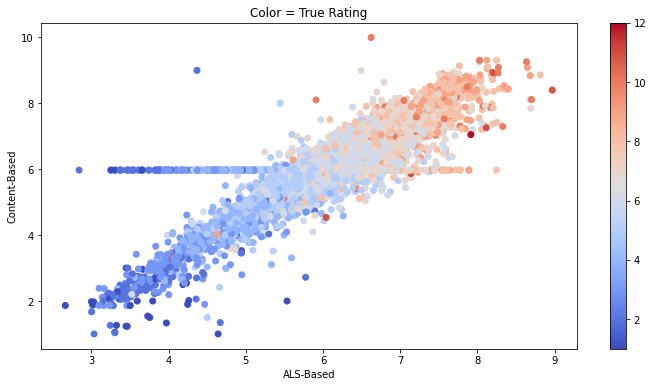

In [ ]:
# visualize
scatter_df = lr_train.sample(10000, random_state=42)
plt.figure(figsize = (12, 6))
plt.scatter(x=scatter_df.als_pred, y=scatter_df.cb_pred_rec, c=scatter_df.target, cmap='coolwarm')
plt.xlabel('ALS-Based')
plt.ylabel('Content-Based')
plt.title('Color = True Rating')
plt.colorbar()

In [ ]:
# Train Linear Regression model
from sklearn.linear_model import LinearRegression

X, y = lr_train.loc[:,lr_train.columns != 'target'], lr_train[['target']]

lr_model = LinearRegression().fit(X,y)

In [ ]:
##### Hybrid - Linear Regression model
# get test set
lr_test = df_als_pred[['r_ui', 'est']].rename(columns={'r_ui':'target', 'est':'als_pred'})
lr_test['cb_pred_rec'] = df_cb_pred_3['est']
X_test, y_test = lr_test.loc[:,lr_test.columns != 'target'], lr_test[['target']]

# predict
lr_pred = lr_model.predict(X_test)

# transform in surprise format
df_lr =  df_als_pred.copy()
df_lr['est'] = lr_pred

In [ ]:
overview = pd.concat([eval.evaluate(df_lr, topn=5, rating_cutoff=5), overview], axis = 1)
overview.rename(columns={'value':'HYBRID_LR'}, inplace = True)
overview

,HYBRID_LR,CB_HYBRID,CB_REC,CB_FREQ,CB_TDIDF,IB,UB,CLU,SVD,ALS
RMSE,0.868621,0.928663,0.995778,1.002499,1.061201,1.155835,1.496085,1.114257,1.421003,0.940659
MAE,0.651895,0.695740,0.724015,0.728852,0.767399,0.829390,1.128415,0.820945,1.004436,0.713441
Recall,0.934747,0.966082,0.949873,0.950623,0.953873,0.955123,0.994916,0.925705,0.832660,0.975791
Precision,0.976537,0.951492,0.951657,0.950267,0.940703,0.922934,0.867718,0.939723,0.942417,0.950985
F1,0.955185,0.958731,0.950764,0.950445,0.947242,0.938753,0.926974,0.932662,0.884145,0.963228
NDCG@5,0.855145,0.856330,0.864225,0.866111,0.864106,0.843581,0.856282,0.852969,0.859563,0.855251


Random Forrest

In [ ]:
# copy lr train set
rf_train = lr_train.copy()
rf_train.head()

,target,als_pred,cb_pred_rec
0,6.0,5.923541,5.842105
1,5.0,5.705231,5.675676
2,6.0,5.720768,5.482759
3,5.0,5.599005,5.756757
4,7.0,7.055771,5.974363


In [ ]:
from sklearn.ensemble import RandomForestRegressor

X, y = rf_train.loc[:,rf_train.columns != 'target'], np.array(rf_train['target'])

# fit random forest model
rf_model = RandomForestRegressor(max_depth=4, n_estimators=100).fit(X,y)

In [ ]:
# predict
rf_pred = rf_model.predict(X_test)

# transform in surprise format
df_rf = df_als_pred.copy()
df_rf['est'] = rf_pred

In [ ]:
overview = pd.concat([eval.evaluate(df_rf, topn=5, rating_cutoff=5), overview], axis = 1)
overview.rename(columns={'value':'HYBRID_RF'}, inplace = True)
overview

,HYBRID_RF,HYBRID_LR,CB_HYBRID,CB_REC,CB_FREQ,CB_TDIDF,IB,UB,CLU,SVD,ALS
RMSE,0.862784,0.868621,0.928663,0.995778,1.002499,1.061201,1.155835,1.496085,1.114257,1.421003,0.940659
MAE,0.652101,0.651895,0.695740,0.724015,0.728852,0.767399,0.829390,1.128415,0.820945,1.004436,0.713441
Recall,0.940748,0.934747,0.966082,0.949873,0.950623,0.953873,0.955123,0.994916,0.925705,0.832660,0.975791
Precision,0.974827,0.976537,0.951492,0.951657,0.950267,0.940703,0.922934,0.867718,0.939723,0.942417,0.950985
F1,0.957484,0.955185,0.958731,0.950764,0.950445,0.947242,0.938753,0.926974,0.932662,0.884145,0.963228
NDCG@5,0.858753,0.855145,0.856330,0.864225,0.866111,0.864106,0.843581,0.856282,0.852969,0.859563,0.855251


We will apply PCA to Content Based Recommendation Recency to try to improve the RMSE

In [ ]:
from sklearn.decomposition import PCA

n_comp = 40
pca = PCA(n_components=n_comp, random_state = 42)
pca.fit(aggregate_3)
pca_data = pd.DataFrame(pca.transform(aggregate_3))
pca_data.head()

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,1177.640329,-1688.935088,1022.050760,-4705.804047,-508.318635,-460.723910,-56.367656,-976.422962,32.180777,59.709923,...,187.581404,312.733162,521.798763,184.696972,735.045865,66.671967,-619.111067,-206.909413,-461.369652,478.887671
1,2484.534573,-1918.760492,790.367359,-5117.628835,99.296852,1928.356703,5670.893280,245.607128,2461.893578,-325.916046,...,-219.812872,-1288.847468,-1095.026200,-801.331135,3039.801683,-291.601374,1464.350487,1852.781444,-2148.855578,195.708254
2,-563.856233,-161.230070,-695.175777,368.023886,-939.366928,-43.989198,-166.920750,-89.951788,-148.053278,363.236754,...,-85.959393,-350.862356,-671.895699,-70.679718,493.119803,222.407920,44.434016,-33.888612,-274.499169,96.848289
3,2725.710542,-2282.762997,40.026103,-4155.651332,-1406.011214,508.926818,-487.106413,-1042.447642,1619.949327,2173.546177,...,1007.641222,-1108.585345,237.095930,801.146867,1276.249760,-1022.990435,-864.716677,-291.880371,-107.201792,-1035.952948
4,-947.030924,-178.132005,358.465299,-290.070152,-388.144241,649.606390,783.846264,200.087677,865.658910,367.566052,...,234.805143,36.769659,-128.787544,-25.452205,-442.868743,292.914544,54.714960,179.510694,-185.008863,85.607755


In [ ]:
cb_pca = ContentBased(NN=10)

# fit on content
cb_pca.fit(pca_data)

# fit on train_ratings
cb_pca.fit_ratings(df_train)

# predict test ratings
cb_pred_4 = cb_pca.test(df_test)

Warning 3973 items are not included in content data: [16385, 16386, 16387, 16388, 16389, 16390, 16391, 16393, 16394, 16404, 16405, 16406, 16407, 16408, 16409, 16410, 16411, 16412, 16415, 16417, 16418, 16419, 16420, 16422, 16423, 16425, 16426, 16427, 16428, 16429, 16430, 16432, 16437, 16438, 16439, 16440, 16441, 16442, 16443, 16444, 16445, 16446, 16447, 16448, 16449, 16451, 16453, 16455, 16456, 16457, 16458, 16459, 16461, 16464, 16465, 16467, 16486, 16490, 16491, 16492, 16493, 16495, 16499, 16500, 16501, 16502, 16503, 16507, 16509, 16510, 16513, 16514, 16515, 16516, 16518, 16519, 16520, 16521, 16527, 16529, 16530, 16531, 16532, 16533, 16535, 16559, 16560, 16561, 16562, 16563, 16564, 16565, 16567, 16568, 16569, 16570, 16572, 16573, 16574, 16575, 16576, 16578, 16580, 16582, 16583, 16584, 16585, 16586, 16587, 16588, 16590, 16591, 16592, 16593, 16594, 16595, 16596, 16598, 16599, 16601, 16604, 16605, 16608, 16610, 16611, 16612, 16613, 16615, 16618, 16619, 16620, 16621, 16622, 16625, 16626, 1

c:\Users\vrajagopalan\OneDrive - IESEG\Desktop\Recommendation\Group_Assignment\IESEGRecSys\model.py:72: RuntimeWarning: invalid value encountered in true_divide
  self.prediction = (np.matmul(df_pivot.values, self.matrixNN) / denom) + self.user_avg[:,np.newaxis]


In [ ]:
overview = pd.concat([eval.evaluate(cb_pred_4, topn=5, rating_cutoff=5), overview], axis = 1)
overview.rename(columns={'value':'CB_PCA'}, inplace = True)
overview

,CB_PCA,HYBRID_RF,HYBRID_LR,CB_HYBRID,CB_REC,CB_FREQ,CB_TDIDF,IB,UB,CLU,SVD,ALS
RMSE,0.969446,0.862784,0.868621,0.928663,0.995778,1.002499,1.061201,1.155835,1.496085,1.114257,1.421003,0.940659
MAE,0.708825,0.652101,0.651895,0.695740,0.724015,0.728852,0.767399,0.829390,1.128415,0.820945,1.004436,0.713441
Recall,0.947831,0.940748,0.934747,0.966082,0.949873,0.950623,0.953873,0.955123,0.994916,0.925705,0.832660,0.975791
Precision,0.959222,0.974827,0.976537,0.951492,0.951657,0.950267,0.940703,0.922934,0.867718,0.939723,0.942417,0.950985
F1,0.953493,0.957484,0.955185,0.958731,0.950764,0.950445,0.947242,0.938753,0.926974,0.932662,0.884145,0.963228
NDCG@5,0.882910,0.858753,0.855145,0.856330,0.864225,0.866111,0.864106,0.843581,0.856282,0.852969,0.859563,0.855251


In [ ]:
df_cb_pred_4 =  pd.DataFrame(cb_pred_4)

In [ ]:
df_hybrid = df_cb_pred_4.copy()
df_hybrid['est'] = (np.array(df_cb_pred_4['est']) + np.array(df_als_pred['est'])) / 2

df_hybrid.head()


,uid,iid,r_ui,est,details
0,200,998,6.0,5.884848,{'was_impossible': False}
1,1833,543,5.0,5.685949,{'was_impossible': False}
2,293,5313,6.0,5.536221,{'was_impossible': False}
3,1102,328,5.0,5.688409,{'was_impossible': False}
4,938,7191,7.0,7.292591,{'was_impossible': False}


In [ ]:
overview = pd.concat([eval.evaluate(df_hybrid, topn=5, rating_cutoff=5), overview], axis = 1)
overview.rename(columns={'value':'CB_PCA_HYBRID'}, inplace = True)
overview

,CB_PCA_HYBRID,CB_PCA,HYBRID_RF,HYBRID_LR,CB_HYBRID,CB_REC,CB_FREQ,CB_TDIDF,IB,UB,CLU,SVD,ALS
RMSE,0.918862,0.969446,0.862784,0.868621,0.928663,0.995778,1.002499,1.061201,1.155835,1.496085,1.114257,1.421003,0.940659
MAE,0.689146,0.708825,0.652101,0.651895,0.695740,0.724015,0.728852,0.767399,0.829390,1.128415,0.820945,1.004436,0.713441
Recall,0.963498,0.947831,0.940748,0.934747,0.966082,0.949873,0.950623,0.953873,0.955123,0.994916,0.925705,0.832660,0.975791
Precision,0.955930,0.959222,0.974827,0.976537,0.951492,0.951657,0.950267,0.940703,0.922934,0.867718,0.939723,0.942417,0.950985
F1,0.959700,0.953493,0.957484,0.955185,0.958731,0.950764,0.950445,0.947242,0.938753,0.926974,0.932662,0.884145,0.963228
NDCG@5,0.854903,0.882910,0.858753,0.855145,0.856330,0.864225,0.866111,0.864106,0.843581,0.856282,0.852969,0.859563,0.855251


In [ ]:
overview = pd.concat([eval.evaluate(cb_pred_4, topn=5, rating_cutoff=5), overview], axis = 1)
overview.rename(columns={'value':'CB_REC_PCA'}, inplace = True)
overview

,CB_REC_PCA,CB_PCA_HYBRID,CB_PCA,HYBRID_RF,HYBRID_LR,CB_HYBRID,CB_REC,CB_FREQ,CB_TDIDF,IB,UB,CLU,SVD,ALS
RMSE,0.969446,0.918862,0.969446,0.862784,0.868621,0.928663,0.995778,1.002499,1.061201,1.155835,1.496085,1.114257,1.421003,0.940659
MAE,0.708825,0.689146,0.708825,0.652101,0.651895,0.695740,0.724015,0.728852,0.767399,0.829390,1.128415,0.820945,1.004436,0.713441
Recall,0.947831,0.963498,0.947831,0.940748,0.934747,0.966082,0.949873,0.950623,0.953873,0.955123,0.994916,0.925705,0.832660,0.975791
Precision,0.959222,0.955930,0.959222,0.974827,0.976537,0.951492,0.951657,0.950267,0.940703,0.922934,0.867718,0.939723,0.942417,0.950985
F1,0.953493,0.959700,0.953493,0.957484,0.955185,0.958731,0.950764,0.950445,0.947242,0.938753,0.926974,0.932662,0.884145,0.963228
NDCG@5,0.882910,0.854903,0.882910,0.858753,0.855145,0.856330,0.864225,0.866111,0.864106,0.843581,0.856282,0.852969,0.859563,0.855251


Logistic Regression PCA

In [ ]:
df_pred_cb_pca = pd.DataFrame(cb_pred_4)

In [ ]:
# training set for Linear Regression model
lr_train = df_als_pred[['r_ui', 'est']].rename(columns={'r_ui':'target', 'est':'als_pred'})
lr_train['cb_rec_pca_pred'] = df_pred_cb_pca['est']
lr_train.head()

,target,als_pred,cb_rec_pca_pred
0,6.0,5.923541,5.846154
1,5.0,5.705231,5.666667
2,6.0,5.720768,5.351673
3,5.0,5.599005,5.777813
4,7.0,7.055771,7.529412


In [ ]:
# Train Linear Regression model
from sklearn.linear_model import LinearRegression

X, y = lr_train.loc[:,lr_train.columns != 'target'], lr_train[['target']]

lr_model_pca = LinearRegression().fit(X,y)

In [ ]:
# get test set
lr_test = df_als_pred[['r_ui', 'est']].rename(columns={'r_ui':'target', 'est':'als_pred'})
lr_test['cb_rec_pca_pred'] = df_pred_cb_pca['est']
X_test, y_test = lr_test.loc[:,lr_test.columns != 'target'], lr_test[['target']]

# predict
lr_pred = lr_model_pca.predict(X_test)

# transform in surprise format
df_lr_pca =  df_als_pred.copy()
df_lr_pca['est'] = lr_pred

In [ ]:
overview = pd.concat([eval.evaluate(df_lr_pca, topn=5, rating_cutoff=5), overview], axis = 1)
overview.rename(columns={'value':'HYBRID_PCA_LR'}, inplace = True)
overview

,HYBRID_PCA_LR,CB_REC_PCA,CB_PCA_HYBRID,CB_PCA,HYBRID_RF,HYBRID_LR,CB_HYBRID,CB_REC,CB_FREQ,CB_TDIDF,IB,UB,CLU,SVD,ALS
RMSE,0.868890,0.969446,0.918862,0.969446,0.862784,0.868621,0.928663,0.995778,1.002499,1.061201,1.155835,1.496085,1.114257,1.421003,0.940659
MAE,0.651761,0.708825,0.689146,0.708825,0.652101,0.651895,0.695740,0.724015,0.728852,0.767399,0.829390,1.128415,0.820945,1.004436,0.713441
Recall,0.935247,0.947831,0.963498,0.947831,0.940748,0.934747,0.966082,0.949873,0.950623,0.953873,0.955123,0.994916,0.925705,0.832660,0.975791
Precision,0.976761,0.959222,0.955930,0.959222,0.974827,0.976537,0.951492,0.951657,0.950267,0.940703,0.922934,0.867718,0.939723,0.942417,0.950985
F1,0.955554,0.953493,0.959700,0.953493,0.957484,0.955185,0.958731,0.950764,0.950445,0.947242,0.938753,0.926974,0.932662,0.884145,0.963228
NDCG@5,0.855824,0.882910,0.854903,0.882910,0.858753,0.855145,0.856330,0.864225,0.866111,0.864106,0.843581,0.856282,0.852969,0.859563,0.855251


Random Forrest

In [ ]:
# copy lr train set
rf_train = lr_train.copy()
rf_train.head()

,target,als_pred,cb_rec_pca_pred
0,6.0,5.923541,5.846154
1,5.0,5.705231,5.666667
2,6.0,5.720768,5.351673
3,5.0,5.599005,5.777813
4,7.0,7.055771,7.529412


In [ ]:
X, y = rf_train.loc[:,rf_train.columns != 'target'], np.array(rf_train['target'])

# fit random forest model
rf_model_pca = RandomForestRegressor(max_depth=4, n_estimators=100).fit(X,y)

In [ ]:
# predict
rf_pred_pca = rf_model_pca.predict(X_test)

# transform in surprise format
df_rf_pca = df_als_pred.copy()
df_rf_pca['est'] = rf_pred_pca

In [ ]:
overview = pd.concat([eval.evaluate(df_rf_pca, topn=5, rating_cutoff=5), overview], axis = 1)
overview.rename(columns={'value':'HYBRID_PCA_RF'}, inplace = True)
overview

,HYBRID_PCA_RF,HYBRID_PCA_LR,CB_REC_PCA,CB_PCA_HYBRID,CB_PCA,HYBRID_RF,HYBRID_LR,CB_HYBRID,CB_REC,CB_FREQ,CB_TDIDF,IB,UB,CLU,SVD,ALS
RMSE,0.863338,0.868890,0.969446,0.918862,0.969446,0.862784,0.868621,0.928663,0.995778,1.002499,1.061201,1.155835,1.496085,1.114257,1.421003,0.940659
MAE,0.651160,0.651761,0.708825,0.689146,0.708825,0.652101,0.651895,0.695740,0.724015,0.728852,0.767399,0.829390,1.128415,0.820945,1.004436,0.713441
Recall,0.941789,0.935247,0.947831,0.963498,0.947831,0.940748,0.934747,0.966082,0.949873,0.950623,0.953873,0.955123,0.994916,0.925705,0.832660,0.975791
Precision,0.974686,0.976761,0.959222,0.955930,0.959222,0.974827,0.976537,0.951492,0.951657,0.950267,0.940703,0.922934,0.867718,0.939723,0.942417,0.950985
F1,0.957955,0.955554,0.953493,0.959700,0.953493,0.957484,0.955185,0.958731,0.950764,0.950445,0.947242,0.938753,0.926974,0.932662,0.884145,0.963228
NDCG@5,0.858197,0.855824,0.882910,0.854903,0.882910,0.858753,0.855145,0.856330,0.864225,0.866111,0.864106,0.843581,0.856282,0.852969,0.859563,0.855251


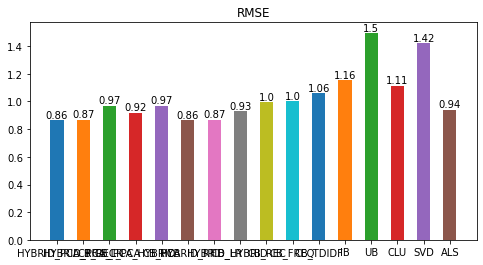

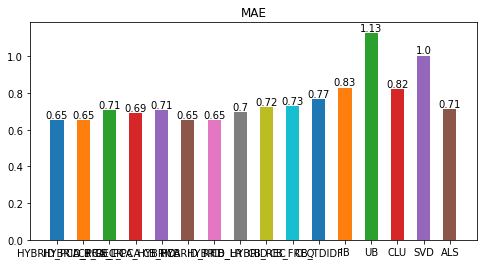

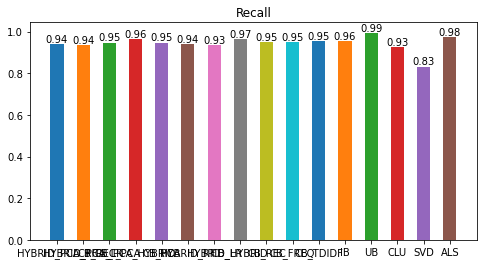

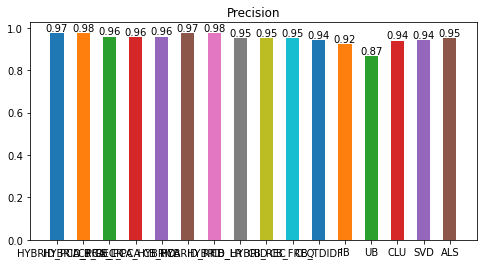

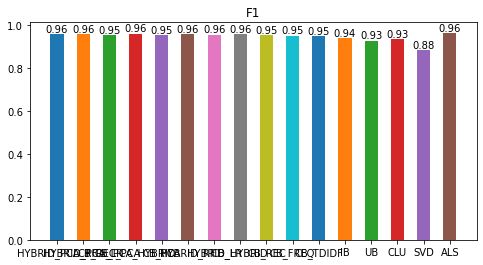

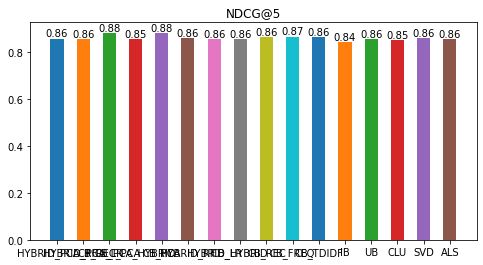

In [ ]:
# simple visualization (Bar Chart)

import matplotlib.pyplot as plt

width = .5

for j, row in enumerate(overview.index):
    fig, ax = plt.subplots(figsize=(8,4))
    x = np.arange(len(overview.columns))
    for i, col in enumerate(overview.columns):
        plt.bar(x[i], overview.iloc[j,i], width, label='col')
        ax.text(x[i], overview.iloc[j,i], str(round(overview.iloc[j,i],2)),
                ha='center', va='bottom')
    ax.set_xticks(x)
    ax.set_title(row)
    ax.set_xticklabels(overview.columns)
    plt.show()

## MODEL EVALUATION

#### Lets check the Evaluation Matrix and go over each.


RMSE :  ROOT MEAN SQUARE ERROR

MAE : MEAN ABSOLUTE ERROR

RECALL : The recall is intuitively the ability of the classifier to find all the positive samples

PRECISION :  The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

F1 :  F1-score combines the precision and recall of a classifier into a single metric

NDCG@5 : Sum the true scores ranked in the order induced by the predicted scores


We would like to have low values for RMSE and MAE as those are the errors. The Lower value indicates that the model is predicting better. We would also like Recall Precision F1 and NDCG@5 score to be higher

Based on these factors we see that in Collaborative filtering ALS algorithm works the best. 
In Content based we have PCA Content Based on Recency which is giving us the best score.

We would be using Hybrid Model Random forrest which is a combination of the ALS and Recency Based Content Based Model to make our recommendations as we the best results based on the factors discussed above.

Lets make recommendations uisng our Hybrid Models

Lets Check the Recommendations for tags based on user using Content based Recency on which PCA was applied.

In [ ]:
df_rf.head()

,uid,iid,r_ui,est,details
0,200,998,6.0,5.845250,{'was_impossible': False}
1,1833,543,5.0,5.565320,{'was_impossible': False}
2,293,5313,6.0,5.609926,{'was_impossible': False}
3,1102,328,5.0,5.336615,{'was_impossible': False}
4,938,7191,7.0,7.103031,{'was_impossible': False}


In [ ]:
results = utils.get_top_n(cb_pred_4,  n = 5,  user_col =  'uid', item_col='iid')
results.head()

,user,item
0,200,"[1397, 1810, 998, 1415, 65]"
1,1833,"[16916, 1440, 543, 292, 295]"
2,293,"[5324, 5311, 498, 412, 5320]"
3,1102,"[328, 467, 4732, 538, 58]"
4,938,"[11219, 7191, 297, 499, 907]"


In [ ]:
result = pd.DataFrame(aggregate_1.loc[aggregate_1.index == 1397, 'tagValue'])
result.head()

,tagValue
artistID,
1397,"[90s, acid, all time faves, beats, big beat, brett, british, chillout, cool, cover, dance, driving music, electro, electro house, electronic, electronica, energetic, house, late night tunes, my electro feelings, play it loud, pop, remix, rock, rock alternative, seen live, soul, trance]"


In [ ]:
result = pd.DataFrame(aggregate_1.loc[aggregate_1.index == 1810, 'tagValue'])
result.head()

,tagValue
artistID,
1810,"[00s, 1981, 1983, 1987, 1992, 1993, 1995, 1996, 1999, 80s, 80s metal, 80s pop metal, 80s rock, 90s, <3, acoustic, alternative, arena rock, artists, atmospheric, baixar, ballad, better than your music, british, classic rock, cover, covers, dance, david bowie, def leppard, early mtv, english, fucking amazing, fun, glam, glam metal, glam rock, hair metal, hard, hard rock, heavy metal, instrumental, live, love song, metal, most favorite song ever, nwobhm, oldie but goodie, omg, pop, pop metal, pop rock, progressive, remix, rock, rock n roll, romantic, seen live, single, song with samples, songs that cheer me up, uk, whoah yeah]"


In [ ]:
result = pd.DataFrame(aggregate_1.loc[aggregate_1.index == 998, 'tagValue'])
result.head()

,tagValue
artistID,
998,"[1008, 80s, 80s pop, alternative, alternative dance, b-side, beautiful, blitz playlist, british, british artists, cities, covers, death, drugs, edit, electronic, experimental, factory records, famous persons, fav artists, favorite bands, favorite tracks, instrumental, level one, liverpool, mad about, my loving, my pleasuredome, new romantic, new wave, old, omd, piano, po-kraftwerkski, pop, random songs, religion, science, slowies, soundtrack, synth pop, synthpop, synthpop artists, the beowulfs choice]"


In [ ]:
result = pd.DataFrame(aggregate_1.loc[aggregate_1.index == 1415, 'tagValue'])
result.head()

,tagValue
artistID,
1415,"[1008, 1968, 1969, 60s, 70s, americana, awesome-ness, blues, blues rock, california, cities, classic rock, cover, covers, creedence cleawater revival, english, epic, folk, folk rock, girls names, guitar solo, i love my dad taste, lovelovelove x 392834, male, oldies, questions, rain, rock, rock and roll, rock n roll, southern fried rock, southern rock, weather]"


We see that the recommended Artist are from 90's, english and have rock tags

### Lets make Recommendation for user 200 using the content based model with recency and PCA

In [ ]:
pca_data.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,1177.640329,-1688.935088,1022.050760,-4705.804047,-508.318635,-460.723910,-56.367656,-976.422962,32.180777,59.709923,...,187.581404,312.733162,521.798763,184.696972,735.045865,66.671967,-619.111067,-206.909413,-461.369652,478.887671
1,2484.534573,-1918.760492,790.367359,-5117.628835,99.296852,1928.356703,5670.893280,245.607128,2461.893578,-325.916046,...,-219.812872,-1288.847468,-1095.026200,-801.331135,3039.801683,-291.601374,1464.350487,1852.781444,-2148.855578,195.708254
2,-563.856233,-161.230070,-695.175777,368.023886,-939.366928,-43.989198,-166.920750,-89.951788,-148.053278,363.236754,...,-85.959393,-350.862356,-671.895699,-70.679718,493.119803,222.407920,44.434016,-33.888612,-274.499169,96.848289
3,2725.710542,-2282.762997,40.026103,-4155.651332,-1406.011214,508.926818,-487.106413,-1042.447642,1619.949327,2173.546177,...,1007.641222,-1108.585345,237.095930,801.146867,1276.249760,-1022.990435,-864.716677,-291.880371,-107.201792,-1035.952948
4,-947.030924,-178.132005,358.465299,-290.070152,-388.144241,649.606390,783.846264,200.087677,865.658910,367.566052,...,234.805143,36.769659,-128.787544,-25.452205,-442.868743,292.914544,54.714960,179.510694,-185.008863,85.607755


In [ ]:
train.head()

,userID,artistID,raw_ratings
0,967,3462,5.0
1,441,225,5.0
2,1356,466,8.0
3,1757,65,5.0
4,1515,344,6.0


In [ ]:
results = predict_user_topn(cb_pca, train, 200, topk=5, item_col='artistID')

In [ ]:
results

[3112, 5376, 971, 9029, 3245]

In [ ]:
result = pd.DataFrame(aggregate_1.loc[aggregate_1.index == 3112, 'tagValue'])
result.head()

,tagValue
artistID,
3112,"[alternative, avant-garde, experimental, folk, indie, indie rock, jazz, mellow, pop, psychedelic, pure sex, rock, singer-songwriter]"


In [ ]:
result = pd.DataFrame(aggregate_1.loc[aggregate_1.index == 5376, 'tagValue'])
result.head()

,tagValue
artistID,


In [ ]:
result = pd.DataFrame(aggregate_1.loc[aggregate_1.index == 971, 'tagValue'])
result.head()

,tagValue
artistID,
971,"[90s, 90s dance, 90s fun, alternative, alternative rock, hecho en mexico, indie, indie pop, indie rock, inlove, male, mexican, mexico, rock, spanish, tinosoft]"


In [ ]:
result = pd.DataFrame(aggregate_1.loc[aggregate_1.index == 9029, 'tagValue'])
result.head()

,tagValue
artistID,


In [ ]:
result = pd.DataFrame(aggregate_1.loc[aggregate_1.index == 3245, 'tagValue'])
result.head()

,tagValue
artistID,
3245,"[alternative metal, approfondire, best unknown bands tracks to be observed, metal, nu metal, nu-metal]"
